In [15]:
import cv2
import numpy as np

cap = cv2.VideoCapture('./downstairs1.mp4')
ret, current_frame = cap.read()
if not ret:
    raise RuntimeError("Could not read video")

previous_frame = current_frame.copy()

h, w = current_frame.shape[:2]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter("diff_video.mp4", fourcc, 10, (w, h))

i = 0
while True:
    ret, current_frame = cap.read()
    if not ret or i >= 10000:
        break

    i += 1
    print("processing frame", i, end="\r")

    current_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
    prev_gray = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)
    
    current_lab = cv2.cvtColor(current_frame, cv2.COLOR_BGR2Lab)
    current_lab[:, :, 0] = 0.5
    prev_lab = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2Lab)
    prev_lab[:, :, 0] = 0.5

    frame_diff = cv2.absdiff(current_lab, prev_lab)
    print(frame_diff.shape)
    frame_diff[:, :, 0] = 0.5
    # diff_rgb = np.stack([frame_diff]*3, axis=-1)

    video.write(frame_diff * 3)

    previous_frame = current_frame.copy()

video.release()
cap.release()


(1080, 1920, 3)e 1
(1080, 1920, 3)e 2
(1080, 1920, 3)e 3
(1080, 1920, 3)e 4
(1080, 1920, 3)e 5
(1080, 1920, 3)e 6
(1080, 1920, 3)e 7
(1080, 1920, 3)e 8
(1080, 1920, 3)e 9
(1080, 1920, 3)e 10
(1080, 1920, 3)e 11
(1080, 1920, 3)e 12
(1080, 1920, 3)e 13
(1080, 1920, 3)e 14
(1080, 1920, 3)e 15
(1080, 1920, 3)e 16
(1080, 1920, 3)e 17
(1080, 1920, 3)e 18
(1080, 1920, 3)e 19
(1080, 1920, 3)e 20
(1080, 1920, 3)e 21
(1080, 1920, 3)e 22
(1080, 1920, 3)e 23
(1080, 1920, 3)e 24
(1080, 1920, 3)e 25
(1080, 1920, 3)e 26
(1080, 1920, 3)e 27
(1080, 1920, 3)e 28
(1080, 1920, 3)e 29
(1080, 1920, 3)e 30
(1080, 1920, 3)e 31
(1080, 1920, 3)e 32
(1080, 1920, 3)e 33
(1080, 1920, 3)e 34
(1080, 1920, 3)e 35
(1080, 1920, 3)e 36
(1080, 1920, 3)e 37
(1080, 1920, 3)e 38
(1080, 1920, 3)e 39
(1080, 1920, 3)e 40
(1080, 1920, 3)e 41
(1080, 1920, 3)e 42
(1080, 1920, 3)e 43
(1080, 1920, 3)e 44
(1080, 1920, 3)e 45
(1080, 1920, 3)e 46
(1080, 1920, 3)e 47
(1080, 1920, 3)e 48
(1080, 1920, 3)e 49
(1080, 1920, 3)e 50
(1080, 19

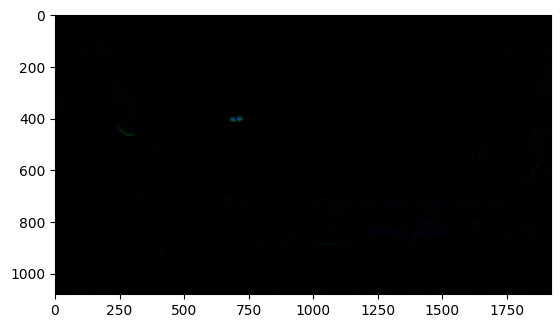

In [16]:
from matplotlib import pyplot as plt

cap = cv2.VideoCapture("./diff_video.mp4")
ret, frame = cap.read()
plt.imshow(frame)